# Project milestone 2 for the group "Florence and the Machine"
Students names: Jangwon Park, Frank Schmutz, Frédéric Myotte, Caroline Moutiez <br/><br/>
In this notebook, you will find our deliverable for the milestone 2 of Ada course project.

## Table of contents
1. [Loading dataset](#Part-I:-Loading-dataset) 
2. [Cleaning tables](#Part-II:-Cleaning-tables) 
3. [Exploratory data analysis](#Part-III:-Exploratory-data-analysis) 
    1. [Products' price and sales over time](#A\)-Products'-price-and-sales-over-time)
    2. [Measuring price elasticity of demand](#B\)-Measuring-price-elasticity-of-demand)
    3. [Measuring complementarity between products](#C\)-Measuring-complementarity-between-products)
    4. [Effect of income and presence of children on food purchases](#D\)-Effect-of-income-and-presence-of-children-on-food-purchases)
4. [Discussions and plan for what comes next](#Part-IV:-Discussions-and-plan-for-what-comes-next)

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
from collections import Counter, OrderedDict
import itertools

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# NLP-specific imports
import re
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Other imports
import heapq
import warnings
warnings.filterwarnings('ignore')
SEED = 1

## Part I: Loading dataset

There are 8 tables in total whose details and relationships are illustrated in the figure below.

<img src="dunnhumby db relations.png" width="700" height="700" align="center"/>

Information related to marketing campaigns and the details about which household redeemed which coupon are provided across four tables: `CAMPAIGN_TABLE`, `CAMPAIGN_DESC`, `COUPON_REDEMPT`, `COUPON`, and `CAUSAL_DATA`. For the exploratory data analysis part, we decided to focus more on the rest of the tables for cleaning and descriptive analysis, namely `HH_DEMOGRAPHIC`, `TRANSACTION_DATA`, and `PRODUCT`. This is because our research is centered around discovering the economics of food purchases, rather than operational aspects of the store, and in particular investigating: how to measure in an accurate way the degree to which products are complementary or substitutable in the microeconomics sense, and how income and presence of children affect food purchase decisions.

In [2]:
# Import tables
hh_demographic = pd.read_csv("../dunnhumby/csv/hh_demographic.csv")
product = pd.read_csv("../dunnhumby/csv/product.csv")
transaction_data = pd.read_csv("../dunnhumby/csv/transaction_data.csv")

In [3]:
# Demographic information about each household
hh_demographic.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [4]:
# Product information
product.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [5]:
# Transaction records
transaction_data.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [6]:
# Checking sizes of the tables we are going to use
hh_demographic.shape, product.shape, transaction_data.shape

((801, 8), (92353, 7), (2595732, 12))

## Part II: Cleaning tables

In this part of the notebook, we are interested in achieving the following tasks:
1. **Find and address any missing values in each of the three tables**. <br/> In the `hh_demographic` table, for example, not all families who shop provided their personal information voluntarily. We want to see how many families in the `transaction_data` table actually have provided demographic information.
2. **Find and address non-sensical values**. <br/> Some transaction records, for example, will report purchased quantity of 0 and/or sales value of 0. As this implies no transaction for that product, we can remove these rows without incurring any loss of information.
3. **Some simple feature processing**. <br/> Again in the transaction records, for instance, we don't actually observe the *actual unit price* of each product. When they do, the actual unit price may be obscured by discounts and coupons. However, we can derive this using a simple formula presented in the User Guide pdf available on the Dunnhumby website.

#### Cleaning of transaction table

In [7]:
# Check for missing (null/na) data in "transaction_data"
for c in transaction_data.columns:
    print('Missing data in column "{}": {}'.format(c,sum(transaction_data[c].isnull())))

Missing data in column "household_key": 0
Missing data in column "BASKET_ID": 0
Missing data in column "DAY": 0
Missing data in column "PRODUCT_ID": 0
Missing data in column "QUANTITY": 0
Missing data in column "SALES_VALUE": 0
Missing data in column "STORE_ID": 0
Missing data in column "RETAIL_DISC": 0
Missing data in column "TRANS_TIME": 0
Missing data in column "WEEK_NO": 0
Missing data in column "COUPON_DISC": 0
Missing data in column "COUPON_MATCH_DISC": 0


We seem to have no missing data, but not all records are meaningful. An example of an invalid transaction record is when the quantity or sales value is 0.

In [8]:
# Check number of rows with QUANTITY == 0 or SALES_VALUE == 0
invalid_rows = transaction_data[(transaction_data.SALES_VALUE == 0) | (transaction_data.QUANTITY == 0)]
print('Number of rows to be removed: ', invalid_rows.shape[0])
invalid_rows.head()

Number of rows to be removed:  18917


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
97,744,26985165432,1,5978648,0,0.0,31582,0.0,1119,1,0.0,0.0
128,1287,26985336468,1,5978648,0,0.0,304,0.0,1351,1,0.0,0.0
249,2305,26996870743,2,5978656,0,0.0,414,0.0,1300,1,-1.0,0.0
293,271,26997082949,2,5978656,0,0.0,329,0.0,1719,1,-2.0,0.0
694,315,27008952267,3,957951,0,0.0,327,0.0,1707,1,0.0,0.0


In [9]:
# Removing these rows loses no information as they contain none.
transaction_data = transaction_data[~((transaction_data.SALES_VALUE == 0) | (transaction_data.QUANTITY == 0))]
transaction_data.shape

(2576815, 12)

There appears to be two kinds of actual unit prices: loyalty card price and non-loyalty card price. By definition, actual unit price derived from loyalty card holders (simply call this LCP) is always larger than or equal to that derived from non-loyalty card holders (call this NLCP) because loyalty card holders receive both the retrail as well as the coupon discounts whereas non-loyalty card holders receive only the latter. Therefore, when LCP > NLCP, we know that the true actual unit price equal to LCP; otherwise, LCP and NLCP should be equivalent and it doesn't matter which one we take.

In [10]:
# Calculate the actual unit product price (formula taken from the User Guide pdf)

# Loyalty card price (LCP)
LCP = (transaction_data.SALES_VALUE - (transaction_data.RETAIL_DISC + \
                                       transaction_data.COUPON_MATCH_DISC))/transaction_data.QUANTITY

# Non-loyalty card price (NLCP)
NLCP = (transaction_data.SALES_VALUE - transaction_data.COUPON_MATCH_DISC)/transaction_data.QUANTITY

# Confirm that there are no 0 quantities because if there were, some values would be nan.
print('Number of missing LCP values: ', sum(LCP.isnull()))
print('Number of missing NLCP values: ', sum(NLCP.isnull()))

Number of missing LCP values:  0
Number of missing NLCP values:  0


In [11]:
# Verify if LCP >= NCLP relationship is indeed true
transaction_data[LCP < NLCP]

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
1215551,1535,32478752229,370,999270,1,7.98,360,3.990000e+00,1852,54,0.0,0.0
1271754,623,32704598135,384,5995423,1,0.51,381,2.600000e-01,1950,56,0.0,0.0
1292342,59,32759986795,389,835530,1,2.50,352,4.440892e-16,1903,56,0.0,0.0
1466571,290,33362690334,433,9575181,2,0.66,367,1.110223e-16,1723,63,0.0,0.0
1785852,367,35080936104,512,10456655,4,1.00,368,1.110223e-16,1537,74,0.0,0.0


It turns out that there are **five rows** which violate the relationship LCP $\geq$ NLCP (out of ~2.5M rows). The common factor in these observations is that `RETAIL_DISC` is positive. A positive `RETAIL_DISC` implies that by applying the discount, the consumer would have paid a higher amount. This is clearly illogical as it would then not be a discount. Therefore, a more comprehensive search is to look for rows that have a positive value under `RETAIL_DISC`.

In [12]:
# Print rows with positive RETAIL_DISC
pos_retail_disc = transaction_data[transaction_data.RETAIL_DISC > 0]
pos_retail_disc

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
1215551,1535,32478752229,370,999270,1,7.98,360,3.990000e+00,1852,54,0.0,0.0
1271754,623,32704598135,384,5995423,1,0.51,381,2.600000e-01,1950,56,0.0,0.0
1292342,59,32759986795,389,835530,1,2.50,352,4.440892e-16,1903,56,0.0,0.0
1466571,290,33362690334,433,9575181,2,0.66,367,1.110223e-16,1723,63,0.0,0.0
1758882,367,34812010763,505,10456655,7,3.50,368,1.110223e-16,1413,73,0.0,0.0
1785852,367,35080936104,512,10456655,4,1.00,368,1.110223e-16,1537,74,0.0,0.0


The entries here effectively overlap with the rows that also have LCP < NLCP (which shouldn't happen). So we can attribute the violation of the "LCP $\geq$ NLCP" condition to the fact that these rows have positive `RETAIL_DISC`. The last four rows, however, don't really matter as their values of `RETAIL_DISC` is basically 0. The first two rows do matter, and we can investigate other rows with the same `PRODUCT_ID` within `TRANSACTION_DATA`.

In [13]:
# Display other rows with the same product ID
transaction_data[(transaction_data.PRODUCT_ID == 999270) & (transaction_data.DAY > 370)].head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
1217954,878,32493312069,371,999270,2,3.99,446,-3.99,1656,54,0.0,0.0
1220183,2084,32493651857,371,999270,2,3.99,389,-3.99,1538,54,0.0,0.0
1220253,210,32493652981,371,999270,2,3.99,389,-3.99,1832,54,0.0,0.0
1221185,1454,32505251935,372,999270,2,3.99,412,-3.99,1440,54,0.0,0.0
1221513,1579,32505311358,372,999270,2,3.99,388,-3.99,1354,54,0.0,0.0


In [14]:
# Display other rows with the same product ID
transaction_data[(transaction_data.PRODUCT_ID == 5995423) & (transaction_data.DAY > 380)].head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
1260616,742,32671515088,382,5995423,1,0.34,445,-0.26,832,55,0.0,0.0
1268604,468,32672365010,383,5995423,3,1.00,338,-0.79,215,55,0.0,0.0
1268605,468,32672365011,383,5995423,3,1.00,338,-0.79,216,55,0.0,0.0
1271754,623,32704598135,384,5995423,1,0.51,381,0.26,1950,56,0.0,0.0
1275551,636,32715925896,385,5995423,3,1.00,300,-0.79,1631,56,0.0,0.0


It appears that we can get the actual unit prices for the first "dirty" row by subtracting the positive `RETAIL_DISC`, thereby giving us 3.99, which matches the unit prices of the same product on similar days. On the other hand, the second "dirty" row seems to have unit prices around 0.60 on other similar days, but it is unclear whether how we can proceed (take the `SALES_VALUE` as is, or subtract `RETAIL_DISC`). Therefore, we choose to remove this second "dirty" row.

In [15]:
# Remove the second "dirty" row
transaction_data = transaction_data.drop([1271754])
transaction_data = transaction_data.reset_index(drop=True)
LCP = LCP.drop([1271754])
LCP = LCP.reset_index(drop=True)

In [16]:
# Create a new feature for the actual unit price (AUP)
transaction_data['AUP'] = LCP

#### Cleaning of the product table

In [17]:
# Check for missing (null/na) data in "product"
for c in product.columns:
    print('Missing data in column "{}": {}'.format(c,sum(product[c].isnull())))

Missing data in column "PRODUCT_ID": 0
Missing data in column "MANUFACTURER": 0
Missing data in column "DEPARTMENT": 0
Missing data in column "BRAND": 0
Missing data in column "COMMODITY_DESC": 0
Missing data in column "SUB_COMMODITY_DESC": 0
Missing data in column "CURR_SIZE_OF_PRODUCT": 0


In [18]:
# However, we know that many entries in the last column are empty
print('Number of empty entries in "CURR_SIZE_OF_PRODUCT": {}'.format((product.CURR_SIZE_OF_PRODUCT==' ').sum()))

Number of empty entries in "CURR_SIZE_OF_PRODUCT": 30607


Missing size of product is not a big deal as we may never use this column. However, there are products which are missing descriptions, so we have no idea what these product are. If we never learn what they are, there is little point is analyzing them economically either.

In [19]:
# Find out which products are missing commodity descriptions
missing_department  = product[product.DEPARTMENT==' ']
missing_department.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
52189,5126087,1,,National,,,
52190,5126088,1,,National,,,
52191,5126106,1,,National,,,
52192,5126107,1,,National,,,
55048,5977100,1,,National,,,


We suspect that these products may have already been taken care of when we removed transactions records with 0 quantities/sales value, which turns out to be true.

In [20]:
# Verify this hypothesis
sales = [transaction_data[transaction_data.PRODUCT_ID == p].SALES_VALUE.unique() \
             for p in missing_department.PRODUCT_ID.unique()]
print(sales) # everything is empty (i.e. not found)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]


#### Creating transactions table for which we have householders information

Here, we are interested in creating a new table of transactions where we remove the transactions for which we do not have any householder information, as this table would serve for further analyses.

In [21]:
keys_hh = set(hh_demographic.household_key.values)
keys_hh_tran = set(transaction_data.household_key.values)
len(keys_hh), len(keys_hh_tran)

(801, 2500)

In [22]:
# Removing transactions for which we don't have any householders information
transaction_data_hh = transaction_data[transaction_data.household_key.isin(keys_hh)]

In [23]:
# As we can see, we still have a good proportion of the transactions remaining
len(transaction_data), len(transaction_data_hh)

(2576814, 1416671)

## Part III: Exploratory data analysis

### A) Products' price and sales over time

To analyze economic relationships later on, we need to look at each products' price and sales over time. One choice is to use `WEEK_NO` as discrete time points. As there are 2 years worth of data, this gives us about max. 100 points in time. However, the actual unit price for a given product may or may not be the same in the same week. We can deal with this by computing the weekly mean actual unit price.

In [24]:
# Filter columns we do not need
filtered_trans = transaction_data[['WEEK_NO','PRODUCT_ID','QUANTITY','AUP']].copy()

# Compute mean AUP per product per week
quantity_sum = filtered_trans.groupby(['WEEK_NO','PRODUCT_ID']).agg('sum')['QUANTITY']
mean_aup = filtered_trans.groupby(['WEEK_NO','PRODUCT_ID']).agg('mean')['AUP']

# Create the dataframe to analyze in further sections of this notebook
df = pd.concat([quantity_sum, mean_aup], axis=1).reset_index()   # Unravels the multi-index into columns
df = df.sort_values(by='WEEK_NO', axis=0).reset_index(drop=True) # Sort chronologically
df.head()

,WEEK_NO,PRODUCT_ID,QUANTITY,AUP
0,1,39592,2,3.39
1,1,1088112,2,1.29
2,1,1087347,1,0.25
3,1,1087106,1,3.49
4,1,1086727,1,5.99


Not all products are bought regularly. So we need to find out which are scarcely purchased.

In [25]:
# Not all products are bought regularly, we find out which products are "scarcely" purchased below
num_weekly_trans = Counter(df.PRODUCT_ID)

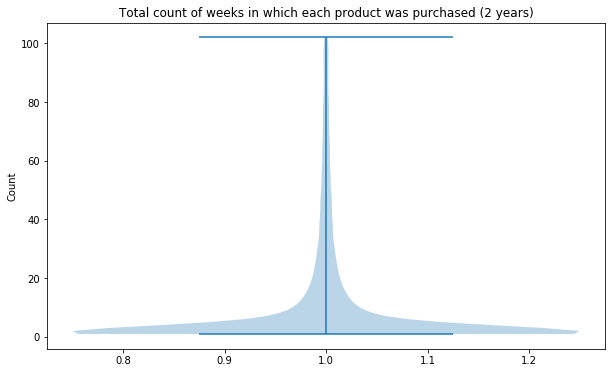

In [26]:
# Visualize the scarcity of purchases
fig = plt.figure(figsize=(10,6))
plt.violinplot(num_weekly_trans.values())
plt.title('Total count of weeks in which each product was purchased (2 years)')
plt.ylabel('Count')
plt.show()

In [27]:
# Find out how many products are bought just once
products_bought_once = [x for x,c in num_weekly_trans.items() if c == 1]
products_bought_twice = [x for x,c in num_weekly_trans.items() if c == 2]
print('% of products bought only once in 2 years: {0:.0f}%'.format(100*len(products_bought_once)/len(num_weekly_trans)))
print('% of products bought only twice in 2 years: {0:.0f}%'.format(100*len(products_bought_twice)/len(num_weekly_trans)))

% of products bought only once in 2 years: 37%
% of products bought only twice in 2 years: 13%


We now know that exactly 50% of all products have been bought only once or twice in 2 years. This is problematic because we expect that in reality some products are necessity good i.e. bought on a weekly basis like food and vegetables, but the above suggests that there are almost no such products.

In [28]:
# Look at what some of these scarce products are
tmp = pd.DataFrame()
for i in range(5):
    id = products_bought_once[i]
    tmp = pd.concat([tmp, product[product.PRODUCT_ID==id]], axis=0)
tmp

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
383,39592,69,DRUG GM,Private,SOAP - LIQUID & BAR,BAR SOAP,25.5 OZ
36127,1087347,544,GROCERY,National,BAG SNACKS,SGL SV/VEND MACH SNACKS CHIP/P,.875 OZ
36541,1090975,58,DRUG GM,National,CANDY - PACKAGED,SEASONAL CANDY BAGS-CHOCOLATE,12 OZ
34580,1073745,693,DRUG GM,National,CANDY - PACKAGED,SEASONAL MISCELLANEOUS,6 PK
34529,1073191,58,DRUG GM,National,CANDY - PACKAGED,SEASONAL CANDY BAGS-CHOCOLATE,12 OZ


We can notice the third and the last items, despite having everthing equal, are somehow treated as separate products. So it's worth looking at all products from manufacturer number 58.

In [29]:
# Look at all candy products made by manufacturer 58
is_candy_bar = product[product.MANUFACTURER == 58]['SUB_COMMODITY_DESC'].apply(lambda x: 'CANDY BAR' in x)

product[(product.MANUFACTURER == 58) & (is_candy_bar)].head(10)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
722,48451,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,1.4 OZ
4684,598890,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,
6648,826099,58,DRUG GM,National,CANDY - PACKAGED,CANDY BARS (MULTI PACK),6 PK
14247,893399,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,
15038,900185,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,1.4 OZ
17167,918772,58,DRUG GM,National,CANDY - PACKAGED,CANDY BARS (MULTI PACK),6 PK
24520,984087,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,
28439,1018679,58,DRUG GM,National,CANDY - PACKAGED,CANDY BARS (SINGLES)(INCLUDING,4 OZ
32641,1056014,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,
36754,1092948,58,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,1.85 OZ


These are just ten items which, despite being candy bars from the same manufacturer, are all unique products. Therefore, it will be useful to analyze, not each product id, but each `SUB_COMMODITY_DESC` category -- lowest granularity available -- for further analysis. We note that while this will still allow us to do meaningful estimation of complementary relationships between categories, competing relationships will no longer be as meaningful since competition is more often discovered *within* each category (but we have removed this possibility by grouping by `SUB_COMMODITY_DESC`). Nevertheless, we can still pursue other research questions such as "how does income of household affect consumption?" or "are there significant differences in consumption based on how many children a household has?"

In [30]:
# Join df with product to get commodity descriptions
df_merged = df.join(product.set_index('PRODUCT_ID'), on='PRODUCT_ID', how='left')
df_merged.head()

,WEEK_NO,PRODUCT_ID,QUANTITY,AUP,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,1,39592,2,3.39,69,DRUG GM,Private,SOAP - LIQUID & BAR,BAR SOAP,25.5 OZ
1,1,1088112,2,1.29,5136,GROCERY,National,VEGETABLES - SHELF STABLE,SPINACH & GREENS,14 OZ
2,1,1087347,1,0.25,544,GROCERY,National,BAG SNACKS,SGL SV/VEND MACH SNACKS CHIP/P,.875 OZ
3,1,1087106,1,3.49,1441,PRODUCE,National,PROCESSED,DRESSINGS,15 OZ
4,1,1086727,1,5.99,764,GROCERY,National,LAUNDRY ADDITIVES,FABRIC SOFTENER SHEETS,120 CT


In [31]:
# Again aggregate quantities and AUP
quantity_sum = df_merged.groupby(['WEEK_NO','COMMODITY_DESC']).agg('sum')['QUANTITY']
mean_aup = df_merged.groupby(['WEEK_NO','COMMODITY_DESC']).agg('mean')['AUP']

df_merged = pd.concat([quantity_sum, mean_aup], axis = 1).reset_index()   # Unravels the multiindex into columns
df_merged = df_merged.sort_values(by='WEEK_NO', axis = 0).reset_index(drop=True) # Sort chronologically
print('New shape: ', df_merged.shape)
# print('Number of unique "products" (subcommodities): ', len(df_merged.SUB_COMMODITY_DESC.unique()))
print('Number of unique "products" (commodities): ', len(df_merged.COMMODITY_DESC.unique()))
df_merged.head()

New shape:  (27453, 4)
Number of unique "products" (commodities):  307


,WEEK_NO,COMMODITY_DESC,QUANTITY,AUP
0,1,ADULT INCONTINENCE,1,3.490
1,1,MELONS,2,2.290
2,1,MILK BY-PRODUCTS,26,2.055
3,1,MISC WINE,2,3.490
4,1,MISC. DAIRY,7,2.390


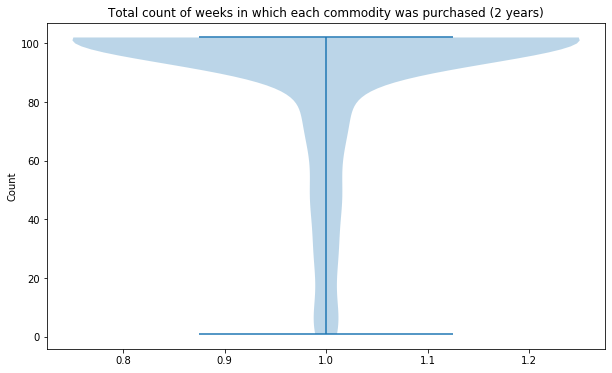

In [32]:
# Visualize the weekly puchases again
num_weekly_trans_merged = Counter(df_merged.COMMODITY_DESC)
fig = plt.figure(figsize = (10,6))
plt.violinplot(num_weekly_trans_merged.values())
plt.title('Total count of weeks in which each commodity was purchased (2 years)')
plt.ylabel('Count')
plt.show()

This distribution is a lot more representative of the reality for a few reasons. First, we have many "products" which are bought almost on a weekly basis. Some examples could be pizza or pancake mix. In the middle we have several "products" which are bought equally frequently, on a more or less biweekly basis. Then we still have some, but considerably fewer, non-common goods which are scarcely bought such as a tricycle or barbeque grills.

In [33]:
# Find which products are bought almost every week
weekly_bought_products = [x for x,y in OrderedDict(num_weekly_trans_merged).items() if y >= 102]
print('Ten items which are bought weekly: \n', weekly_bought_products[:10])

# Find whici products are bought rarely
rare_products = [x for x,y in OrderedDict(num_weekly_trans_merged).items() if y < 2]
print('\nTen items which are bought rarely: \n', rare_products[:10])

Ten items which are bought weekly: 
 ['MELONS', 'MILK BY-PRODUCTS', 'MISC WINE', 'MISC. DAIRY', 'MISCELLANEOUS', 'MOLASSES/SYRUP/PANCAKE MIXS', 'MUSHROOMS', 'NO COMMODITY DESCRIPTION', 'OLIVES', 'ONIONS']

Ten items which are bought rarely: 
 ['MISCELLANEOUS(CORP USE ONLY)', 'EASTER LILY', 'MISCELLANEOUS CROUTONS', 'FROZEN PACKAGE MEAT']


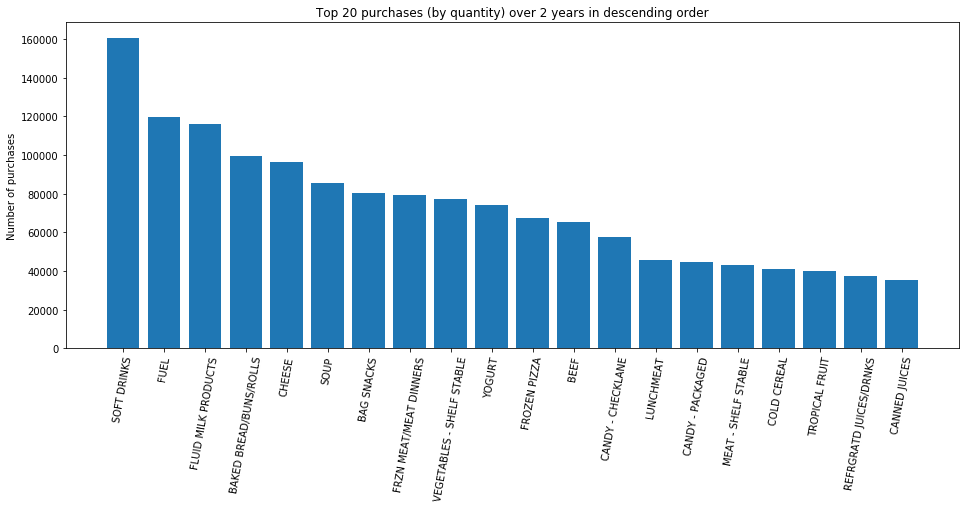

In [34]:
# Find most bought products over 2 years
qty_sorted = df_merged.groupby('COMMODITY_DESC').agg('sum')['QUANTITY'].sort_values(ascending = False)
N = 20
fig,ax = plt.subplots(figsize = (16,6))
ax.bar(np.arange(0,N,1), qty_sorted.iloc[1:N+1].values)
ax.set_xticks(np.arange(0,N,1))
ax.set_xticklabels(qty_sorted.index[1:N+1],rotation = 80)
ax.set_ylabel('Number of purchases')
ax.set_title('Top 20 purchases (by quantity) over 2 years in descending order')
plt.show()

Above excludes gasoline since its 'quantities sold' are overwhemingly high compared to the rest.

An interesting finding is that products which are bought regularly are not necessarily among the top 20 most bought products. Additionally, we may still be able to analyze competing relationships, despite grouping by subcommpodities. For example, in the top 20 ranking above, "SOFT DRINKS" products can come in either cans or in powder pouches. It would be interesting to see if these are competing choices, for instance.

### B) Measuring price elasticity of demand
First, we can measure each products' *elasticity of demand*, which describes the **percent change in quantity demanded followed by 1% change in its price**. To this end, we can follow these steps:
1. Select a product and filter the dataframe for its unique ID (`PRODUCT_ID` column).
2. Compute the elasticities between every pair of adjacent discrete time points (using `WEEK_NO`), which will produce X number of values. 
3. Produce an average of X elasticities. 
4. Repeat for all other products.

In [35]:
# Let's compute the price elasticity of demand for a few products
product_elasticity = {}

for item in df_merged.COMMODITY_DESC.unique()[:10]:
    item_df = df_merged[df_merged.COMMODITY_DESC == item]
    item_elasticity = []
    
    num_weeks = len(item_df)
    if num_weeks > 1:
        previous_week = item_df.iloc[0]
        for i in range(num_weeks):
            current_week = item_df.iloc[i]
            
            if current_week.AUP != previous_week.AUP:
                percent_price_change = (current_week.AUP / previous_week.AUP - 1) * 100
                elasticity = (current_week.QUANTITY / previous_week.QUANTITY - 1)  * 100 / percent_price_change
                item_elasticity.append(elasticity)
            
            previous_week = current_week
    
    if len(item_elasticity) > 0:
        product_elasticity[item] = np.mean(item_elasticity)

In [36]:
product_elasticity

{'ADULT INCONTINENCE': 1.1697906608476794,
 'MELONS': 157858131268647.8,
 'MILK BY-PRODUCTS': -11.31634872479654,
 'MISC WINE': -7.632926532032537,
 'MISC. DAIRY': -19988663419534.56,
 'MISCELLANEOUS': 0.03245405040356183,
 'MOLASSES/SYRUP/PANCAKE MIXS': -3.8612535941506096,
 'MUSHROOMS': -0.05175853794461483,
 'NO COMMODITY DESCRIPTION': -0.419492170995051,
 'OLIVES': 29.81663138881084}

Using the initially proposed method, we find that there is so much variation in the data that the elasticities do not make any sense. As an alternative, let's try to *group by AUP*, take the mean quantities for each AUP and perform linear regression. The slope of the linear regression model will describe the average change in quantities with price and hence yields a natural interpretation of elasticity.

In [37]:
def plot_price_and_quantity(item):
    item_df = df_merged[df_merged.COMMODITY_DESC == item]
    y = item_df.groupby('AUP').agg('mean')['QUANTITY']
    x = y.index
    plt.figure(figsize=(10, 3))
    plt.title(item + ' elasticity')
    plt.scatter(x, y)
    plt.xlabel('AUP')
    plt.ylabel('QUANTITY')
    
    line_fit = np.polyfit(x, y, 1)
    line = np.poly1d(line_fit)
    
    # Compute elasticity
    min_price = np.unique(x).min()
    max_price = np.unique(x).max()
    min_qty = line(min_price)
    max_qty = line(max_price)
    
    percent_price_increase = (max_price / min_price - 1) * 100
    elasticity = (max_qty / min_qty - 1) * 100 / percent_price_increase
    
    plt.title(item + '\nElasticity: ' + str(np.round(elasticity, 2)))
    
    plt.plot(np.unique(x), np.poly1d(line_fit)(np.unique(x)), color='red')

In [38]:
df_merged.COMMODITY_DESC.unique()[:20]

array(['ADULT INCONTINENCE', 'MELONS', 'MILK BY-PRODUCTS', 'MISC WINE',
       'MISC. DAIRY', 'MISCELLANEOUS', 'MOLASSES/SYRUP/PANCAKE MIXS',
       'MUSHROOMS', 'NO COMMODITY DESCRIPTION', 'OLIVES', 'ONIONS',
       'ORAL HYGIENE PRODUCTS', 'ORGANICS FRUIT & VEGETABLES',
       'PAPER HOUSEWARES', 'PAPER TOWELS', 'PASTA SAUCE', 'PEPPERS-ALL',
       'PET CARE SUPPLIES', 'PICKLE/RELISH/PKLD VEG', 'PIES'],
      dtype=object)

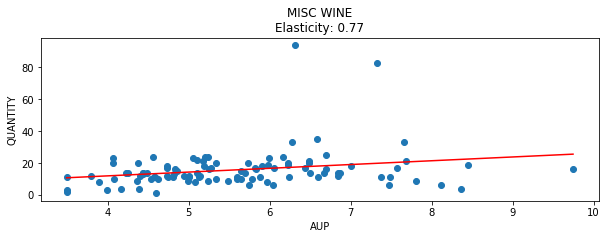

In [39]:
plot_price_and_quantity('MISC WINE')

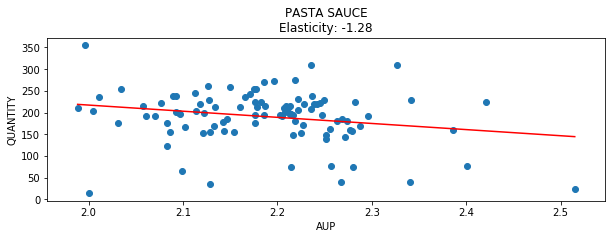

In [40]:
plot_price_and_quantity('PASTA SAUCE')

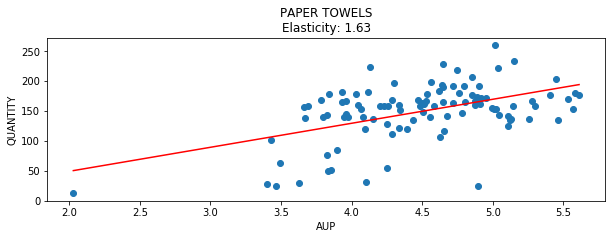

In [41]:
plot_price_and_quantity('PAPER TOWELS')

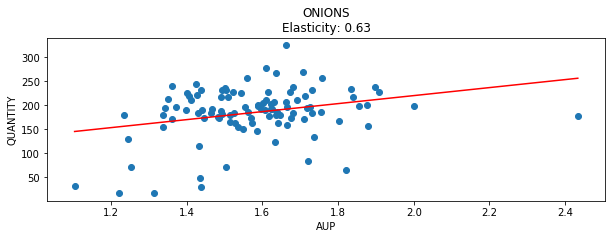

In [42]:
plot_price_and_quantity('ONIONS')

We can't have a very high confidence in the linear regressions because of the high frequency variation in the data.  
To try and fix this, we compute the average quantity purchased in each price bin and then try a linear regression. 
Moreover, we try and use a common, alternative formula for computing elasticities, which is called the midpoint formula, to reduce the variation in elasticiticies.

<img src="midpoint_method.jpeg" style="width: 350px;"/>

In [43]:
def midpoint_elasticity(q1,q2,p1,p2):
    percent_qty_change = (q2-q1)/((q1+q2)/2)
    percent_prc_change = (p2-p1)/((p1+p2)/2)
    return percent_qty_change/percent_prc_change

def bin_price_and_quantity(item):
    item_df = df_merged[df_merged.COMMODITY_DESC == item]
    y = item_df.groupby('AUP').agg('mean')['QUANTITY']
    x = y.index
    quantities_sum, bins = np.histogram(x, bins=10, weights=y)
    num_prices, _ = np.histogram(x, bins=10)
    
    # Remove empty bins
    zero_idx = np.argwhere(np.array(quantities_sum) == 0)
    zero_idx = zero_idx.reshape((zero_idx.size,))
    quantities_sum = np.delete(quantities_sum, zero_idx)
    num_prices = np.delete(num_prices, zero_idx)
    
    quantities = [s/t for s, t in zip(quantities_sum, num_prices)]
    prices = [(s+t)/2 for s, t in zip(bins[:-1], bins[1:])]
    prices = np.delete(prices, zero_idx)
    return prices, quantities

def plot_price_and_quantity_bin(item):
    prices, quantities = bin_price_and_quantity(item)
    
    plt.figure(figsize=(10, 3))
    plt.scatter(prices, quantities)
    plt.xlabel('AUP')
    plt.ylabel('QUANTITY')
    
    line_fit = np.polyfit(prices, quantities, 1)
    line = np.poly1d(line_fit)
    
    # Compute elasticity
    min_price = np.unique(prices).min()
    max_price = np.unique(prices).max()
    min_qty = line(min_price)
    max_qty = line(max_price)
    
    percent_price_increase = (max_price / min_price - 1) * 100
    elasticity = midpoint_elasticity(min_qty, max_qty, min_price, max_price)
    
    plt.title(item + '\nElasticity: ' + str(np.round(elasticity, 2)))
    plt.plot(np.unique(prices), line(np.unique(prices)), color='red')

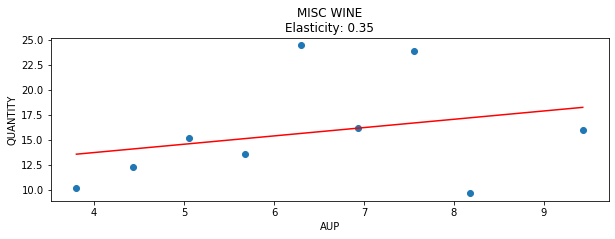

In [44]:
plot_price_and_quantity_bin('MISC WINE')

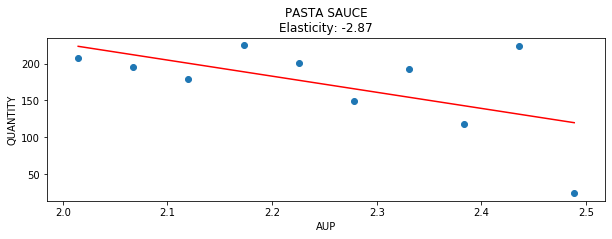

In [45]:
plot_price_and_quantity_bin('PASTA SAUCE')

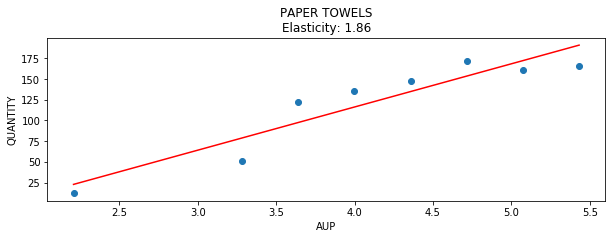

In [46]:
plot_price_and_quantity_bin('PAPER TOWELS')

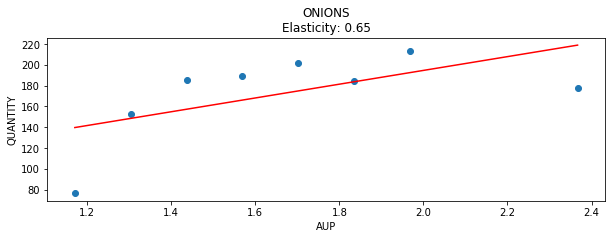

In [47]:
plot_price_and_quantity_bin('ONIONS')

The linear regression fit appears more reliable as mainly due to less variability of the observations within each product. Furthermore, the use of the midpoint formula helps avoid overstating the magnitudes of the elasticities.

Now we consider more seriously the limitations of our dataset. In practice, reliable computations of price elasticities require many observations gathered over several years, especially for rarely purchased items. Computations with limited data points are bound to give high varying -- and probably inaccurate -- results if the dataset spans a short time. For example, to evaluate the price elasticity of a tricycle or a barbeque grill from our dataset, which only has a few points over two years, is largely meaningless as we cannot be confident in its measure. In other words, our dataset only limits us to analyze items which are "common" or "somewhat common".

The notion of "common" is subject to personal interpretations, but we define it to be all items for which there are at least 27 observations in our datafarme (`df_merged`). This is because 27 observations imply that they had been purchased over a period of at least 6 months dispersed throughout the time span of our dataset (two years). Based on the second violinplot above, we still retain the majority of items in our dataset this way.

In [48]:
# Get items for which we have at least 27 observations
weekly_item_count = Counter(df_merged.COMMODITY_DESC)
common_goods = [x for x,c in weekly_item_count.items() if c >= 27]
print('Number of unique "common" items: ', len(common_goods))

# Filter dataframe on common goods
df_filtered = df_merged.copy()
for g in set(weekly_item_count.keys())-set(common_goods):
    df_filtered = df_filtered[df_filtered.COMMODITY_DESC != g]

print('Shape of filtered dataframe: ', df_filtered.shape)

Number of unique "common" items:  290
Shape of filtered dataframe:  (27282, 4)


In [49]:
# Compute elasticities of all products
elasticities = {}
for g in df_filtered.COMMODITY_DESC.unique():
    prcs, qtys = bin_price_and_quantity(g)
    
    # Fit linear regression
    line_fit = np.polyfit(prcs, qtys, 1)
    line = np.poly1d(line_fit)
    
    min_prc = np.unique(prcs).min()
    max_prc = np.unique(prcs).max()
    elasticities[g] = midpoint_elasticity(line(min_prc), line(max_prc), min_prc, max_prc)

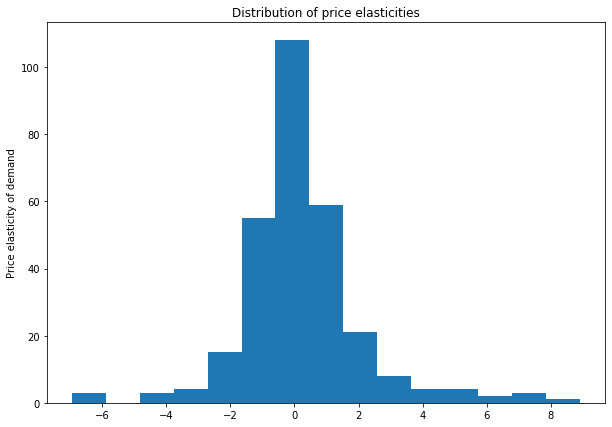

In [50]:
values = np.array([e for g,e in elasticities.items() if ~np.isnan(e)])
fig = plt.figure(figsize = (10,7))
plt.hist(values, bins = 15)
plt.ylabel('Price elasticity of demand')
plt.title('Distribution of price elasticities')
plt.show()

The majority of the products have elasticities close to 0. One striking observation of this distribution is that there are many products with positive elasticities. In principle, price elasticities of demand are always negative; this is because the law of demand states that when a good's price increases, its quantity demanded decreases. 

However, goods with positive elasticities do occur in real life and they are formally called the [Giffen products](https://www.investopedia.com/terms/g/giffen-good.asp). In reality, Giffen products are rare; however, given the limited time span of our dataset and the fact that our figures aren't economy-wide, this may be plausible. Giffen products tend to be low-budget, non-luxury goods with few available substitutes such as rice, potatos, wheat, soap, toilet paper, or even certain packaged meat items. 

Our guess is that if a product has a positive elasticity, then it is likely such a product.

In [51]:
# Get Giffen products (less than 1 can be argued to be non-significant i.e. inelastic)
giffen_products = [g for g,e in elasticities.items() if e > 1] 

# Concatenate product descriptions into one large string
document = ''
counter = 0
for g in giffen_products:
    counter += 1
    document += df_filtered[df_filtered.COMMODITY_DESC==g].COMMODITY_DESC.unique()[0].lower() + ' '

In [52]:
# Remove all special characters including punctuations
txt = re.sub('[^0-9a-zA-Z]', ' ', document)

# Remove reduncant spaces
txt = re.sub(' +', ' ', txt)

# Use gensim's simple preprocess to clean up further
txt = ' '.join(simple_preprocess(txt))

# Create a bigram model for better context
nltk.download('punkt')
bigram = gensim.models.Phrases(txt, min_count=1, threshold=1)
bigram_mod = gensim.models.phrases.Phraser(bigram)
txt = ' '.join(bigram_mod[word_tokenize(txt)])

# Lemmatize
# You have to execute "python -m spacy download en_core_web_lg" in a shell to be able to load it
nlp = spacy.load('en_core_web_sm')
doc = nlp(txt)
txt = [token.lemma_ for token in doc]

# Remove some custom stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['all','non','food','other','cold','hot','misc','product','care'])
txt = [t for t in txt if t not in stop_words]

[nltk_data] Downloading package punkt to /home/frederic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/frederic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total number of unique terms:  105


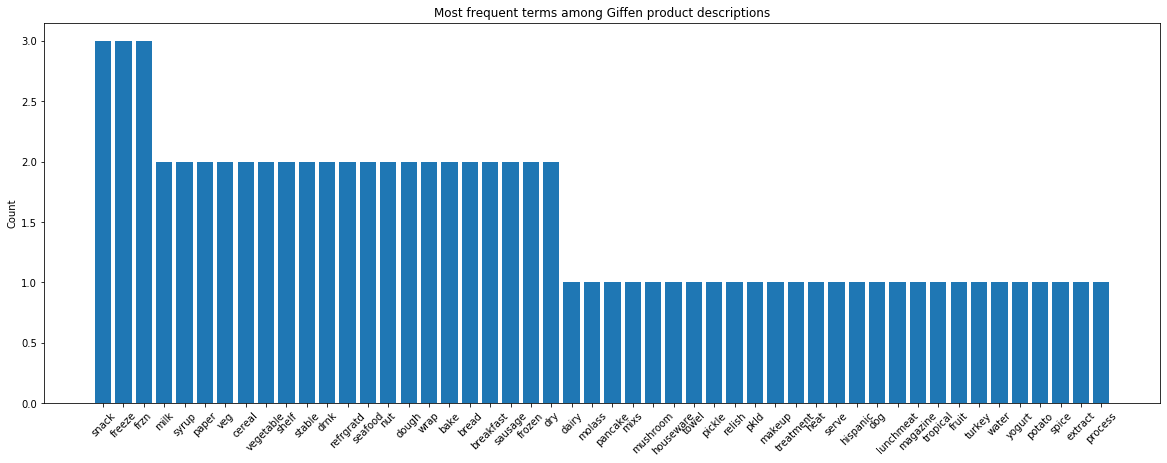

In [53]:
print('Total number of unique terms: ', len(set(txt)))
tf = Counter(txt).most_common(50)
xaxis = [g for g,x in tf]
yaxis = [x for g,x, in tf]

fig, ax = plt.subplots(figsize=(20,7))
ax.bar(np.arange(1,len(yaxis)+1,1), yaxis)
ax.set_xticks(np.arange(1,len(yaxis)+1,1))
ax.set_xticklabels(xaxis, rotation=45)
ax.set_title('Most frequent terms among Giffen product descriptions')
ax.set_ylabel('Count')
plt.show()

Indeed, we can notice that the products with positive elasticities (aka. Giffen products) are typically low-budget, non-luxury items. In the top rankings, we see the term "frozen" and "frzn", most probably alluding to frozen food packages that are generally cheap. We also see many indications "bread" (dough, bake, bread, etc.) in accordance with our initial guess. There are also many indications of dairy products in this ranking, which are likewise non-luxury, essential goods. 

In principle, price elasticity should be negative. But in reality, this may not always be the case since there are too many effects that have an influence. Another thing we can try is to use the total expenditure (equal to quantity * aup) instead of quantity alone. This may give less volatile results.

In [54]:
def plot_price_and_expenditure_bin(item):
    item_df = df_merged[df_merged.COMMODITY_DESC == item].copy()
    item_df['EXPENDITURE'] = item_df.QUANTITY * item_df.AUP
    
    y = item_df.groupby('AUP').agg('sum')['EXPENDITURE']
    x = y.index
    quantities_sum, bins = np.histogram(x, bins=10, weights=y)
    num_prices, _ = np.histogram(x, bins=10)
    
    # Remove empty bins
    zero_idx = np.argwhere(np.array(quantities_sum) == 0)
    zero_idx = zero_idx.reshape((zero_idx.size,))
    quantities_sum = np.delete(quantities_sum, zero_idx)
    num_prices = np.delete(num_prices, zero_idx)
    
    quantities = [s/t for s, t in zip(quantities_sum, num_prices)]
    prices = [(s+t)/2 for s, t in zip(bins[:-1], bins[1:])]
    prices = np.delete(prices, zero_idx)
    
    plt.figure(figsize=(10, 3))
    plt.scatter(prices, quantities)
    plt.xlabel('AUP')
    plt.ylabel('TOTAL EXPENDITURE')
    
    line_fit = np.polyfit(prices, quantities, 1)
    line = np.poly1d(line_fit)
    
    # Compute elasticity
    min_price = np.unique(prices).min()
    max_price = np.unique(prices).max()
    min_qty = line(min_price)
    max_qty = line(max_price)
    
    percent_price_increase = (max_price / min_price - 1) * 100
    elasticity = (max_qty / min_qty - 1) * 100 / percent_price_increase
    
    plt.title(item + '\nExpenditure: ' + str(np.round(elasticity, 2)))
    
    plt.plot(np.unique(prices), line(np.unique(prices)), color='red')

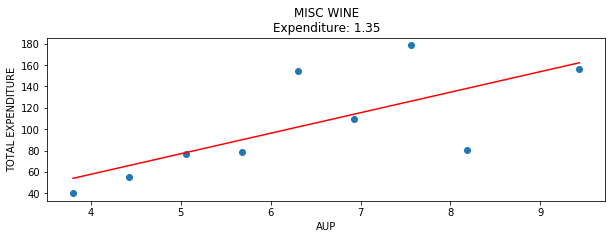

In [55]:
plot_price_and_expenditure_bin('MISC WINE')

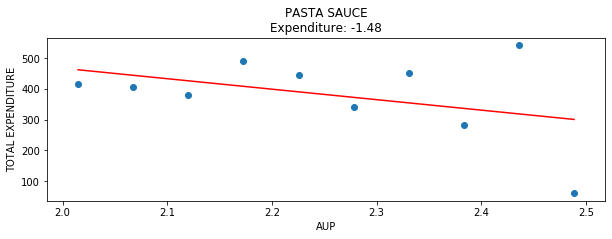

In [56]:
plot_price_and_expenditure_bin('PASTA SAUCE')

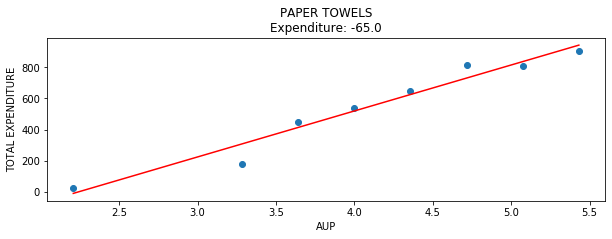

In [57]:
plot_price_and_expenditure_bin('PAPER TOWELS')

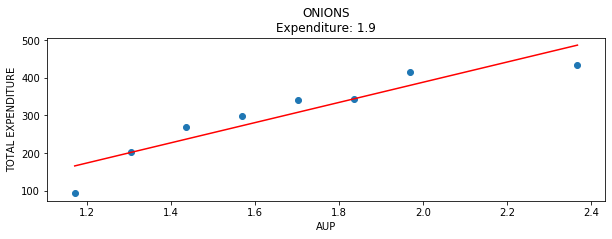

In [58]:
plot_price_and_expenditure_bin('ONIONS')

Finally, one last thing to try is to use linear regression on historical data, that is evolution of expenditure along time stamps. That might be interesting to quantitfy sells of a product while taking into account the date. However, we should keep in mind that we only have data over two years that is sparse for a lot of "uncommon" products, and that might influence results in a bad manner (divergence from expectations).

In [59]:
from sklearn.linear_model import LinearRegression

def plot_expenditure_over_time(item):
    item_df = df_merged[df_merged.COMMODITY_DESC == item].copy()
    item_df['EXPENDITURE'] = item_df.QUANTITY * item_df.AUP
    
    X = item_df['WEEK_NO'].values.reshape(-1, 1)
    Y = item_df['EXPENDITURE'].values.reshape(-1, 1)

    plt.plot(X, Y)
    
    lin_reg = LinearRegression()
    lin_reg.fit(X, Y)
    Y_pred = lin_reg.predict(X)
    
    # Compute elasticity
    min_price = np.unique(Y_pred).min()
    max_price = np.unique(Y_pred).max()
    
    # len(X) does represent the number of weeks with values for this item
    percent_price_increase = (max_price / min_price - 1) * 100
    elasticity = len(X) / percent_price_increase
    
    plt.title(item + '\nExpenditure over time: ' + str(np.round(elasticity, 2)))
    plt.plot(X, Y_pred, color='red')

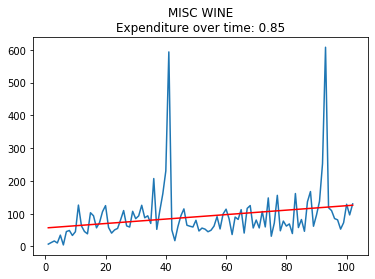

In [60]:
plot_expenditure_over_time('MISC WINE')

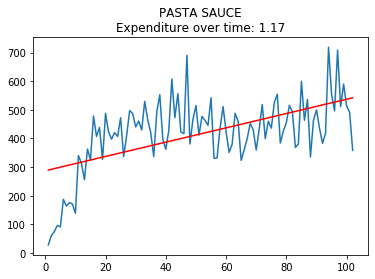

In [61]:
plot_expenditure_over_time('PASTA SAUCE')

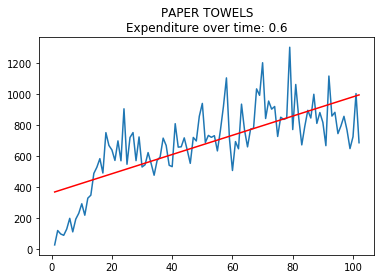

In [62]:
plot_expenditure_over_time('PAPER TOWELS')

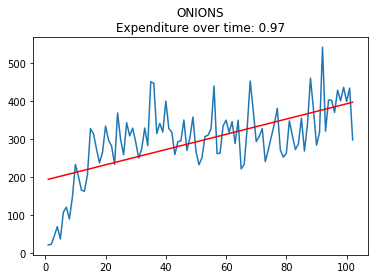

In [63]:
plot_expenditure_over_time('ONIONS')

### C) Measuring complementarity between products
Price elasticity of demand looks at each product independently. However, two products' relationship (either complementary or substitutable) can be computed using the *cross price elasticity of demand*. Given products A and B, it describes the percent change in the quantity demanded of product A upon 1% change in the price of product B, and vice versa. This work will become the ground for our main result, which is the visualization of product relationships in a network.

Our main steps are as follows:
1. Join two items by weeks so as to compare their price and quantity changes over the same time frame.
2. Plot one item's prices vs. the other's quantities (and vice versa) and perform linear regression using the "binning" approach as before to redue variability within data.
3. Obtain the cross elasticity from the slope of the linear regression fit, again using the midpoint formula for elasticity.

In [64]:
def bin_price_and_quantity_two_products(items):
    # Price of item 1 on item 2's quantities and vice versa
    y1 = items.groupby('AUP_1').agg('mean')['QUANTITY_2']
    y2 = items.groupby('AUP_2').agg('mean')['QUANTITY_1']
    
    x1 = y1.index
    x2 = y2.index
    
    qty_sum1, bins1 = np.histogram(x1, bins = 10, weights = y1)
    qty_sum2, bins2 = np.histogram(x2, bins = 10, weights = y2)
    
    # Binning
    num_prices1, _ = np.histogram(x1, bins = 10)
    num_prices2, _ = np.histogram(x2, bins = 10)
    
    # Remove empty bins
    zero_idx1 = np.argwhere(np.array(qty_sum1) == 0)
    zero_idx1 = zero_idx1.reshape((zero_idx1.size,))
    zero_idx2 = np.argwhere(np.array(qty_sum2) == 0)
    zero_idx2 = zero_idx2.reshape((zero_idx2.size,))
    qty_sum1 = np.delete(qty_sum1, zero_idx1)
    qty_sum2 = np.delete(qty_sum2, zero_idx2)
    num_prices1 = np.delete(num_prices1, zero_idx1)
    num_prices2 = np.delete(num_prices2, zero_idx2)
    
    qtys1 = [s/t for s, t in zip(qty_sum1, num_prices1)]
    prices1 = [(s+t)/2 for s, t in zip(bins1[:-1], bins1[1:])]
    prices1 = np.delete(prices1, zero_idx1)
    
    qtys2 = [s/t for s, t in zip(qty_sum2, num_prices2)]
    prices2 = [(s+t)/2 for s, t in zip(bins2[:-1], bins2[1:])]
    prices2 = np.delete(prices2, zero_idx2)
    return qtys1, qtys2, prices1, prices2

def plot_price_and_quantity_bin_two_products(items, plot = 1):
    qtys1, qtys2, prcs1, prcs2 = bin_price_and_quantity_two_products(items)
    
    if plot:
        plt.figure(figsize = (10, 3))
        plt.scatter(prcs1, qtys1)
        plt.xlabel('AUP')
        plt.ylabel('QUANTITY')

    # Two regressions
    line_fit1 = np.polyfit(prcs1, qtys1, 1)
    line1 = np.poly1d(line_fit1)
    line_fit2 = np.polyfit(prcs2, qtys2, 1)
    line2 = np.poly1d(line_fit2)
    
    # Compute elasticity
    min_price1 = np.unique(prcs1).min()
    max_price1 = np.unique(prcs1).max()
    min_qty1 = line1(min_price1)
    max_qty1 = line1(max_price1)
    min_price2 = np.unique(prcs2).min()
    max_price2 = np.unique(prcs2).max()
    min_qty2 = line2(min_price2)
    max_qty2 = line2(max_price2)
    
    cross_elasticity1 = midpoint_elasticity(max_qty1, min_qty1, max_price1, min_price1)
    cross_elasticity2 = midpoint_elasticity(max_qty2, min_qty2, max_price2, min_price2)
    
    # Cross elasticity is the average
    cross_elasticity = (cross_elasticity1 + cross_elasticity2)/2
    
    if plot:
        plt.title(items.COMMODITY_DESC_1.unique()[0] +' and ' \
                  + items.COMMODITY_DESC_2.unique()[0] + '\nCross Elasticity: ' \
                  + str(np.round(cross_elasticity, 2)))
        plt.plot(np.unique(prcs1), line1(np.unique(prcs1)), color='red')
    return cross_elasticity

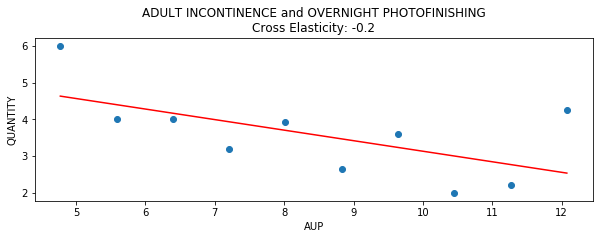

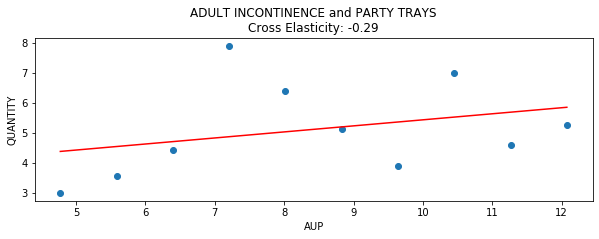

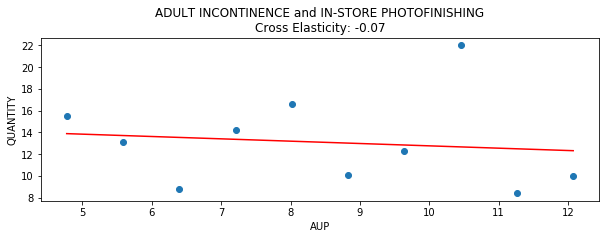

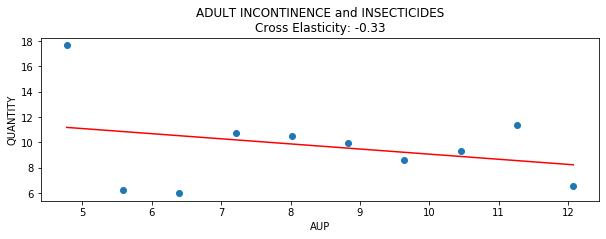

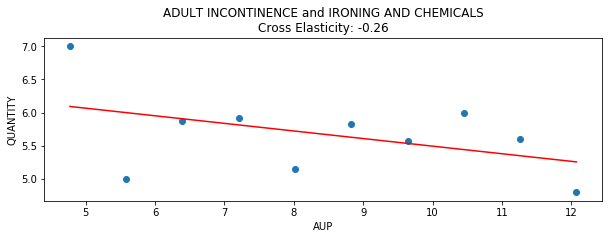

In [65]:
# Form every pair of products
pairs = itertools.combinations(list(df_filtered.COMMODITY_DESC.unique()), 2)

# Experiment with a few pairs
for pair in list(pairs)[200:205]:
    item1_df = df_filtered[df_filtered.COMMODITY_DESC == pair[0]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    item2_df = df_filtered[df_filtered.COMMODITY_DESC == pair[1]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    
    # Join by week number -- make sure that we observe along the same time frame
    joined_df = item1_df.join(item2_df, how = 'inner', lsuffix = '_1', rsuffix = '_2')
    joined_df.sort_index(inplace = True)
    
    if joined_df.shape[0] <= 1:
        continue # Need more than one overlapping time indices to compute elasticity!
    
    plot_price_and_quantity_bin_two_products(joined_df)

In the above, we show the cross elasticity example with adult incontinence product -- which is very particular -- with five other products. We expect the first item to be largely independent on any other product's prices, which we can verify to some extent above. The magnitude of the cross elasticities is less than 1, which suggests that adult incontinence is *inelastic* to price changes in the other goods.

In [66]:
# First, collect all pairwise cross elasticities
pairs = itertools.combinations(list(df_filtered.COMMODITY_DESC.unique()), 2)
cross_elasticities = {}
for pair in list(pairs):
    item1_df = df_filtered[df_filtered.COMMODITY_DESC == pair[0]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    item2_df = df_filtered[df_filtered.COMMODITY_DESC == pair[1]].sort_values(by = 'WEEK_NO').set_index('WEEK_NO')
    
    # Join by week number 
    joined_df = item1_df.join(item2_df, how = 'inner', lsuffix = '_1', rsuffix = '_2')
    joined_df.sort_index(inplace=True)
    
    if joined_df.shape[0] <= 1:
        continue 
    ce = plot_price_and_quantity_bin_two_products(joined_df, plot = 0)
    
    # Update dictionary
    cross_elasticities[(joined_df.COMMODITY_DESC_1.unique()[0], joined_df.COMMODITY_DESC_2.unique()[0])] = ce

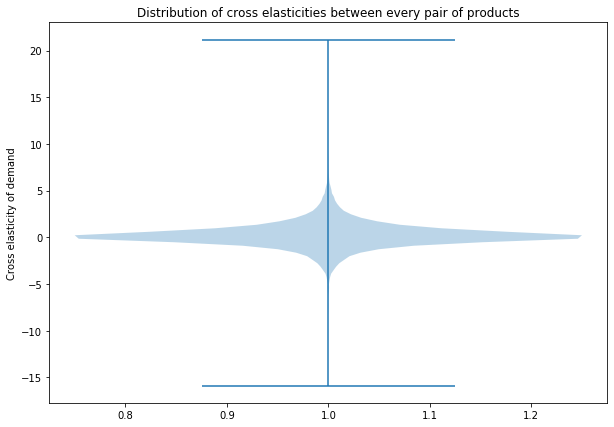

In [67]:
# Verify that cross elasticities are mostly positive
vals = [y for x,y in cross_elasticities.items()]
fig = plt.figure(figsize = (10,7))
plt.violinplot(vals)
plt.title('Distribution of cross elasticities between every pair of products')
plt.ylabel('Cross elasticity of demand')
plt.show()

### D) Effect of income and presence of children on food purchases
Given householders set, we might want to study how purchases vary along some parameters, and see if there are correlations between these pairs. An additional idea is to represent householders as nodes (size of node being proportional to income), put jaccard similarities between sets of bought products as edges, and then see if we can form clusters and figure out that some products or sets of products are related to a certain type of revenue.

First, we modify the household dataframe to include only relevant information.

In [68]:
# Look at the possible values for the household income
hh_demographic['INCOME_DESC'].unique()

array(['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
       '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K'],
      dtype=object)

In [69]:
def parse_income(income):
    if '-' in income:
        # take the average of the bounds
        bounds = income.split('-')
        res = (int(bounds[0]) + int(bounds[1][:-1])) / 2
    elif '+' in income:
        # if it's 250K+ assume it's 250K
        res = int(income.split('+')[0][:-1])
    else:
        res = int(income.split(' ')[-1][:-1])
    return 1000 * res

hh_demographic['income'] = hh_demographic.apply(lambda row: parse_income(row['INCOME_DESC']), axis=1)

In [70]:
# Look at the possible values for the household composition
hh_demographic['HH_COMP_DESC'].unique()

array(['2 Adults No Kids', '2 Adults Kids', 'Single Female', 'Unknown',
       'Single Male', '1 Adult Kids'], dtype=object)

In [71]:
# Look at the possible values for the household size
hh_demographic['HOUSEHOLD_SIZE_DESC'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

In [72]:
# Look at the possible values for the household children
hh_demographic['KID_CATEGORY_DESC'].unique()

array(['None/Unknown', '1', '2', '3+'], dtype=object)

In [73]:
def parse_children(composition, hh_size, kids):
    tot_size = int(hh_size.split('+')[0])
    
    if 'Single' in composition or '1' in composition:
        nb_adults = 1
    elif '2' in composition:
        nb_adults = 2
    else:
        # assume it's 2 adults by default and correct later if contradictory data
        nb_adults = 2
    
    if kids == 'None/Unknown':
        # assume it's 0 kids by default and correct later if contradictory data
        nb_kids = 0
    else:
        nb_kids = int(kids.split('+')[0])
    
    if nb_kids + nb_adults == tot_size:
        nb_children = nb_kids
    elif nb_kids + nb_adults > tot_size:
        # We have overestimated the number of adults
        nb_children = nb_kids
    else:
        # We have underestimated the number of kids
        nb_children = tot_size - nb_adults
    return nb_children

hh_demographic['children'] = hh_demographic.apply(
    lambda row: parse_children(
        row['HH_COMP_DESC'], 
        row['HOUSEHOLD_SIZE_DESC'], 
        row['KID_CATEGORY_DESC']
    ), 
    axis=1
)

In [74]:
# Created a new dataframe with the relevent information, i.e. household_key, income and number of children
household_df = hh_demographic[['household_key', 'income', 'children']]
household_df.head()

,household_key,income,children
0,1,42000.0,0
1,7,62000.0,0
2,8,29500.0,1
3,13,87000.0,2
4,16,62000.0,0


Now we group the transactions by product and household.

In [75]:
transaction_data_hh.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,AUP
11,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19
12,1364,26984896261,1,897044,1,2.99,31742,-0.40,1520,1,0.0,0.0,3.39
13,1364,26984896261,1,920955,1,3.09,31742,0.00,1520,1,0.0,0.0,3.09
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,3.49
15,1364,26984896261,1,981760,1,0.60,31742,-0.79,1520,1,0.0,0.0,1.39


In [76]:
# First filter columns we don't need
filtered_trans_hh = transaction_data_hh[['household_key','PRODUCT_ID','SALES_VALUE']].copy()

# Compute total expenditure per product per household
total_expenditure = filtered_trans_hh.groupby(['household_key', 'PRODUCT_ID']).agg('sum')['SALES_VALUE']

df = total_expenditure.reset_index() # Unravels the multiindex into columns
df = df.sort_values(by = 'household_key', axis = 0).reset_index(drop = True) # Sort by household
df.head()

,household_key,PRODUCT_ID,SALES_VALUE
0,1,819312,5.67
1,1,1111870,7.72
2,1,1112333,0.46
3,1,1113385,2.17
4,1,1115576,6.50


In [77]:
# Join df with product to get commodity descriptions
df_merged_hh = df.join(product.set_index('PRODUCT_ID'), on='PRODUCT_ID', how='left')
df_merged_hh.head()

,household_key,PRODUCT_ID,SALES_VALUE,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,1,819312,5.67,3262,DRUG GM,National,IN-STORE PHOTOFINISHING,ONE HOUR PROCESSING,
1,1,1111870,7.72,1266,GROCERY,National,PNT BTR/JELLY/JAMS,PRESERVES JAM MARMALADE,18 OZ
2,1,1112333,0.46,2,PRODUCE,National,VEGETABLES - ALL OTHERS,GREENS,25 LB
3,1,1113385,2.17,693,DRUG GM,National,CANDY - PACKAGED,SEASONAL CANDY BAGS-CHOCOLATE,13 OZ
4,1,1115576,6.50,1183,GROCERY,National,BAKED BREAD/BUNS/ROLLS,ENGLISH MUFFINS/WAFFLES,12 OZ


In [78]:
# Again aggregate expenditures
tot_expenditure_hh = df_merged_hh.groupby(['household_key','COMMODITY_DESC']).agg('sum')['SALES_VALUE']

df_merged_hh = tot_expenditure_hh.reset_index()   # Unravels the multiindex into columns
df_merged_hh = df_merged_hh[df_merged_hh['COMMODITY_DESC']!='NO COMMODITY DESCRIPTION']
df_merged_hh = df_merged_hh.sort_values(by='household_key', axis=0).reset_index(drop=True) # Sort by household
df_merged_hh.head()

,household_key,COMMODITY_DESC,SALES_VALUE
0,1,AIR CARE,57.66
1,1,PORK,4.45
2,1,POPCORN,2.00
3,1,PNT BTR/JELLY/JAMS,52.67
4,1,PIES,22.94


In [79]:
# Now, let's compute the average weekly spending for each household on each product
transaction_weeks = transaction_data_hh[['household_key', 'WEEK_NO']]
num_weeks_per_household = transaction_weeks.groupby(['household_key']).WEEK_NO.nunique()

# Merge with number of weeks the household participated in
df_merged_hh = df_merged_hh.join(num_weeks_per_household, on='household_key', how='left')
df_merged_hh['weekly_expenditure'] = df_merged_hh.apply(lambda row: row['SALES_VALUE'] / row['WEEK_NO'], axis = 1)

# Keep only relevant info
df_merged_hh = df_merged_hh[['household_key', 'COMMODITY_DESC', 'weekly_expenditure']]
df_merged_hh.head()

,household_key,COMMODITY_DESC,weekly_expenditure
0,1,AIR CARE,0.847941
1,1,PORK,0.065441
2,1,POPCORN,0.029412
3,1,PNT BTR/JELLY/JAMS,0.774559
4,1,PIES,0.337353


In [80]:
cutoff = 0.1
print(
    str(np.round(
        100*np.sum(np.array(list(df_merged_hh.weekly_expenditure)) > cutoff) / len(df_merged_hh.weekly_expenditure),1
    )) +
    '% of products have a weekly expenditure greater than $' + str(cutoff)
)

68.7% of products have a weekly expenditure greater than $0.1


In [81]:
# Let's discard unimportant products (weekly_expenditure < 10 cents)
df_merged_hh = df_merged_hh[df_merged_hh.weekly_expenditure > 0.1]
df_merged_hh.head()

,household_key,COMMODITY_DESC,weekly_expenditure
0,1,AIR CARE,0.847941
3,1,PNT BTR/JELLY/JAMS,0.774559
4,1,PIES,0.337353
8,1,PAPER HOUSEWARES,0.973088
9,1,ORAL HYGIENE PRODUCTS,0.495882


In [82]:
# Helper function to convert data to dict for each household
def household_dict(household_key):
    df = df_merged_hh[df_merged_hh['household_key']==household_key]
    return df.set_index('COMMODITY_DESC').to_dict()['weekly_expenditure']

# Compute the size of the intersection of the two dicts, 
# weighted by the ratio between the lowest and highest expenditure for each product
def intersect_dicts(dict1, dict2):
    keys = set(dict1.keys()) & set(dict2.keys())
    intersection_score = 0
    for key in keys:
        intersection_score += min(dict1[key], dict2[key]) / max(dict1[key], dict2[key])
    return intersection_score

# Compute the size of the union of the two dicts
def union_dicts(dict1, dict2):
    keys = set(dict1.keys()) | set(dict2.keys())
    union_score = len(keys)
    return union_score

# Compute the Jaccard similarity where the intersection is weighted 
# by the difference in expenditure for each product
def similarity(dict1, dict2):
    return intersect_dicts(dict1, dict2) / union_dicts(dict1, dict2)

In [83]:
# Convert each household to a dict
household_dicts = {}
for key in household_df['household_key']:
    household_dicts[key] = household_dict(key)

In [84]:
# Create a similarity dict with an entry for each pair of households
hh_similarity_dict = {}

for pair in itertools.combinations(list(household_df['household_key']), 2):
    hh_similarity_dict[pair] = similarity(household_dicts[pair[0]], household_dicts[pair[1]])

In [85]:
# Let's look at some numbers
print(
    'min value: ' + str(min(hh_similarity_dict.values())), 
    'max value: ' + str(max(hh_similarity_dict.values()))
)
cutoff = 0.2
print(
    str(np.round(
        100*np.sum(np.array(list(hh_similarity_dict.values())) > cutoff) / len(hh_similarity_dict), 1
    )) + '% above cutoff of ' + str(cutoff))

min value: 0.008860139421811342 max value: 0.4165959120023241
46.9% above cutoff of 0.2


We can see that 46.9% of pairs of households a similarity value greate than 0.2.

In [86]:
# Get the 10000 pairs of households with the highest similarity of expenditure
k = 10000
top_pairs = heapq.nlargest(k, hh_similarity_dict, key=hh_similarity_dict.get)

hh_df = household_df.set_index('household_key')

# Let's see how many of them have households in the same income range, with the same number of children and both
nb_same_income = 0
nb_same_children = 0
nb_same_both = 0
for pair in top_pairs:
    hh1 = hh_df.loc[pair[0]]
    hh2 = hh_df.loc[pair[1]]
    
    if hh1.income == hh2.income:
        nb_same_income += 1
    
    if hh1.children == hh2.children:
        nb_same_children += 1
    
    if hh1.income == hh2.income and hh1.children == hh2.children:
        nb_same_both += 1

print('Of the 10,000 most similar households in terms of purchases:')
print(str(np.round(100 * nb_same_income / k, 1)) + '% are in the same income range.')
print(str(np.round(100 * nb_same_children / k, 1)) + '% have the same number of children.')
print(str(np.round(100 * nb_same_both / k, 1)) + '% are in the same income range and have the same number of children.')

Of the 10,000 most similar households in terms of purchases:
16.3% are in the same income range.
37.9% have the same number of children.
7.2% are in the same income range and have the same number of children.


In [87]:
expected_same_income_range_if_no_correlation = np.round(
    100*len(household_df.income.unique()) / sum(range(len(household_df.income.unique()) + 1)), 
    1
)
expected_same_children_if_no_correlation = np.round(
    100*len(household_df.children.unique()) / sum(range(len(household_df.children.unique()) + 1)), 
    1
)
expected_same_both_if_no_correlation = np.round(
    100*(len(household_df.income.unique()) + len(household_df.children.unique())) /
    sum(range(len(household_df.income.unique()) + len(household_df.children.unique()) + 1)), 
    1
)

print('If there is no correlation:')
print(str(expected_same_income_range_if_no_correlation) + '% are expected to be in the same income range.')
print(str(expected_same_children_if_no_correlation) + '% are expected to have the same number of children.')
print(str(expected_same_both_if_no_correlation) + 
      '% are expected to be in the same income range and have the same number of children.')

If there is no correlation:
15.4% are expected to be in the same income range.
33.3% are expected to have the same number of children.
11.1% are expected to be in the same income range and have the same number of children.


We can see that we roughly get the numbers we expect if there was no correlation between the income range, number of chidren and purchases of children.

A possible explanation is that there are only a few products related with the household income range and number of children.  
Another is that the products related to those factors were purchased in other (perhaps specialized in luxury items / items related to children) stores not included in this dataset.

## Part IV: Discussions and plan for what comes next
After having acquired and cleaned the data, we figured out a couple of things that allowed us to sharpen our initial objectives for this project. For example, in a lot of scenarios we confirmed that the lack of data for some analyses leads to inconsistent results considering our initial hypotheses. <br/>

Moving on to milestone 3, we now have a couple of objectives as well as an informed plan for what comes next:
1. Explore other methods of measuring the relationships among products such as the correlation among quantities sold as an alternative to measuring cross price elasticities of demand. Verify if one method is more intuitive than the others.
2. Visualize the economic relationships in the form of a network. The weights of the edges can be the degree to which products are complementary/substitutable as measured by the method decided in step 1. To avoid a dense network, we plan to experiment with a few thresholds on the weight of the edges to determine what "counts" as a strong enough relationship.
3. Explore methods of comparing the similarity of the types of goods bought between households of various income level. Such a method could include Jaccard similarity.
4. Also visualize these relationships in a network (separate) where the node size can represent the income level and the weight of the edges represents the similarity in the basket of goods purchased between households.
5. Construct clusters in these graphs to see if we can create an economically intuitive groups based on these relationships. For example, we may be able to cluster dairy products and cereal products naturally from the first network, which makes intuitive sense, or identify other surprising groups. From the second network, we may be able to identify patterns in how households of similar income levels consume similar goods.